## 3.1.1 통계 기반 기법의 문제점

- 통계 기반 기법 : 주변 단어의 빈도를 기초로 단어를 표현
    - 단어의 동시 발생 행렬을 만들고 그 행렬에 SVD(차원 감소를 위한 특잇값 분해)를 적용하여 밀집벡터(단어의 분산 표현)을 얻었다.
- **그러나** 대규모 말뭉치를 다룰때는 데이터가 커져서 문제가 생긴다.

추론 기반 기법에서는...
- 신경망을 이용하는 경우 미니배치로 학습한다.
- 나눠 학습하기 때문에 학습 속도를 높일 수 있다.

## 3.1.2 추론 기반 기법 개요
맥락을 입력하면 모델은 각 단어의 출현 확률을 출력한다.  
이 틀 안에서 말뭉치를 사용해 모델이 올바른 추측을 내놓도록 학습시킨다. 

## 3.1.3. 신경망에서의 단어 처리
먼저 단어를 '고정 길이의 벡터'로 변환시켜야 하는데, 이 방법이 **'원핫 벡터'** 로 변환하는 것이다. 'You ___ goodbye and I say hello'에서 입력층의 뉴런은 총 7개이고, 각 해당되는 단어의 자리에 1을 부여한다.

| 단어(텍스트) | 단어 ID | one-hot vector        |
| ------------ | ------- | --------------------- |
| you          | 0       | [1, 0, 0, 0, 0, 0, 0] |
| goodbye      | 2       | [0, 0, 1, 0, 0, 0, 0] |

이 신경망은 완전연결계층이므로 각각의 노드가 이웃 층의 모든 노드와 연결되어 있다. 이 사이에는 weight가 존재하여, 입력층 뉴런과의 **가중합**이 **hidden layer**가 된다.

In [1]:
import numpy as np

c=np.array([[1,0,0,0,0,0,0]]) #입력층 (one-hot)
W=np.random.randn(7,3)        #가중치 (랜덤한 값) 7x3크기의 행렬
h=np.matmul(c,W)              #은닉층 노드
print(h)

[[ 0.99034566 -0.18093763  1.04543645]]


완전연결계층의 계산은 행렬 곱으로 수행할 수 있고, 행렬 곱은 넘파이의 np.matmul()이 해결해준다.  
위의 코드에서 c는 원핫 표현이며, 단어 ID에 대응하는 원소만 1이고 그 외에는 0인 벡터이다.  
따라서, c와 W의 행렬곱은 가중치 W의 행벡터 하나를 뽑아낸 것과 같다.

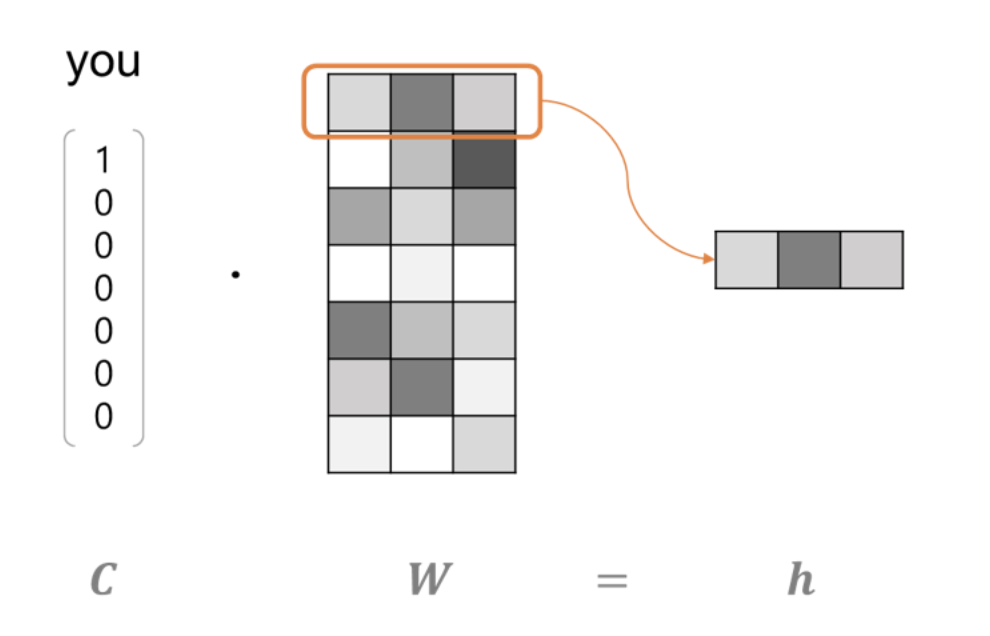

# 3.2 단순한 word2vec
## 3.2.1. CBOW 모델의 추론 처리
- **CBOW(Continuous Bag-Of-Words)** 모델은 맥락(context, 주변 단어)로부터 타깃(target, 중심 단어)을 추측하는 신경망이다.
- 따라서 입력은 맥락이다. ("say"양 옆으로 있는 "you", "goodbye")

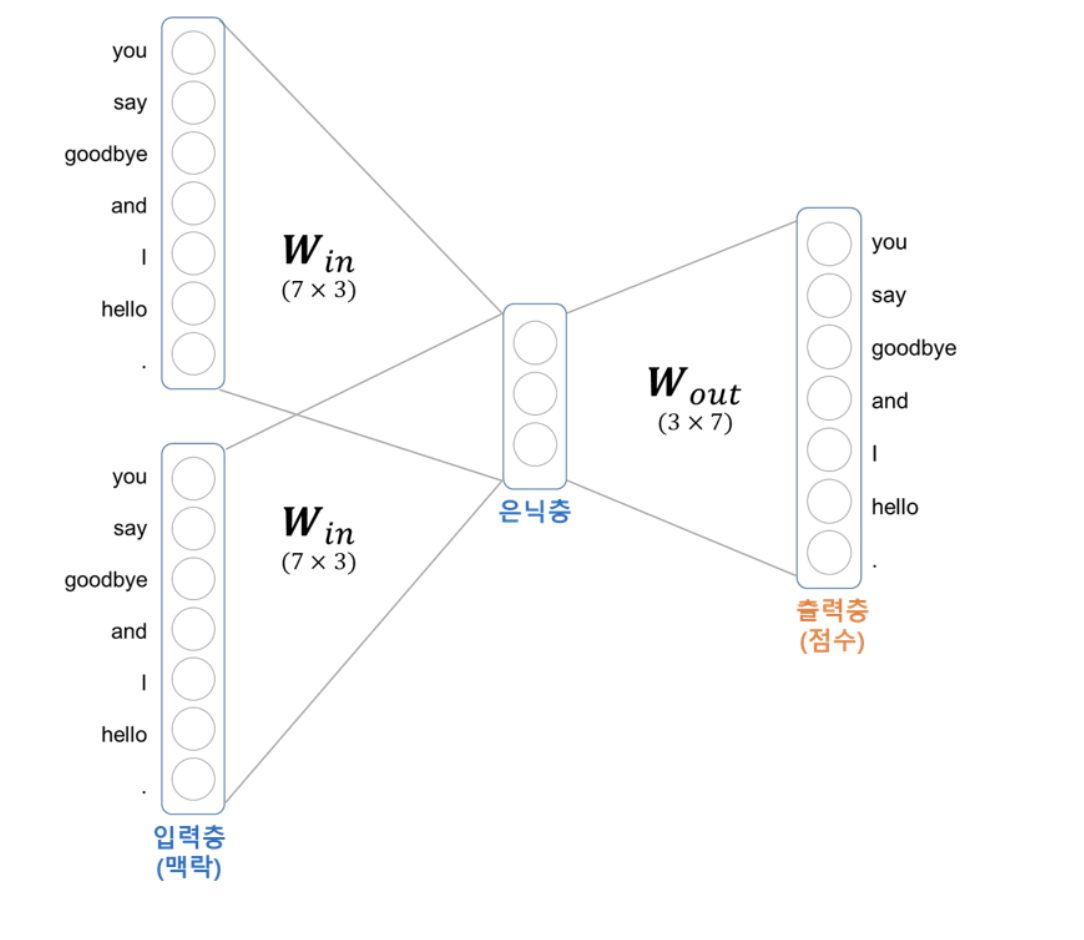
- 입력층이 2개있고, 은닉층을 거쳐 출력층에 도달한다. 
    - *입력층이 2개인 이유*는 맥락으로 고려할 단어를 2개("you","goodbye")로 정했기 때문이다. 즉, 맥락에 포함시킬 단어가 N개 라면 입력층도 N개이다.
- **은닉층**의 뉴런은 입력층의 완전연결계층에 의해 변환된 값이 되는데, 입력층이 여러개이면 전체를 '평균'한다.
    - ex) 완전연결계층에 의한 첫번째 입력층이 h1으로 변환되고, 두번째 입력층이 h2로 변환되었다고 하면, 은닉층의 뉴런은 1/2(h1+h2)가 되는 것이다.
- **출력층**의 뉴런은 총 7개인데, 해당 단어의 수(vocab_size)과 같고, 이 뉴런 하나하나가 각각의 단어에 대응한다. 
    - 출력층의 뉴런은 각 단어의 점수를 뜻하며, 점수가 높을수록 대응 단어의 출현 확률도 높아진다. softmax 함수를 적용해서 확률을 얻을 수 있다.
- Win의 각 행과 Wout의 각 열이 바로 단어의 분산 표현이 된다.
- 따라서 학습을 진행할수록 맥락에서 출현하는 단어를 잘 추측하는 방향으로 이 분산 표현들이 갱신된다. 또한 이곳에는 '단어의 의미'도 잘 녹아들어 있다!!

### CBOW 모델의 추론 처리

In [1]:
import sys

In [5]:
import numpy as np

In [6]:
from common.layers import MatMul

In [8]:
#샘플 맥락 데이터
c0=np.array([[1,0,0,0,0,0,0]])
c1=np.array([[0,0,1,0,0,0,0]])

In [9]:
#가중치 초기화
W_in=np.random.randn(7,3)
W_out=np.random.randn(3,7)

In [10]:
#계층 생성
in_layer0=MatMul(W_in)
in_layer1=MatMul(W_in) #고려하고자 하는 맥락이 2개이기 때문에 2개 생성 / 이때 가중치 W_in을 공유한다.
out_layer=MatMul(W_out)

In [13]:
#순전파
h0=in_layer0.forward(c0) #forward()메서드 : 중간 데이터를 계산하고 출력층 측의 MatMul 계층을 통과시켜 각 단어의 점수를 구한다.
h1=in_layer1.forward(c1)
h=0.5*(h0+h1)
s=out_layer.forward(h)

In [14]:
print(s) #각 단어의 점수 출력

[[-0.31111659 -0.4772918   0.66144138 -1.04230938 -0.84849331  0.50064811
  -0.6378273 ]]


### 3.2.2 CBOW 모델의 학습
- 올바른 예측을 할 수 있도록 가중치 조정
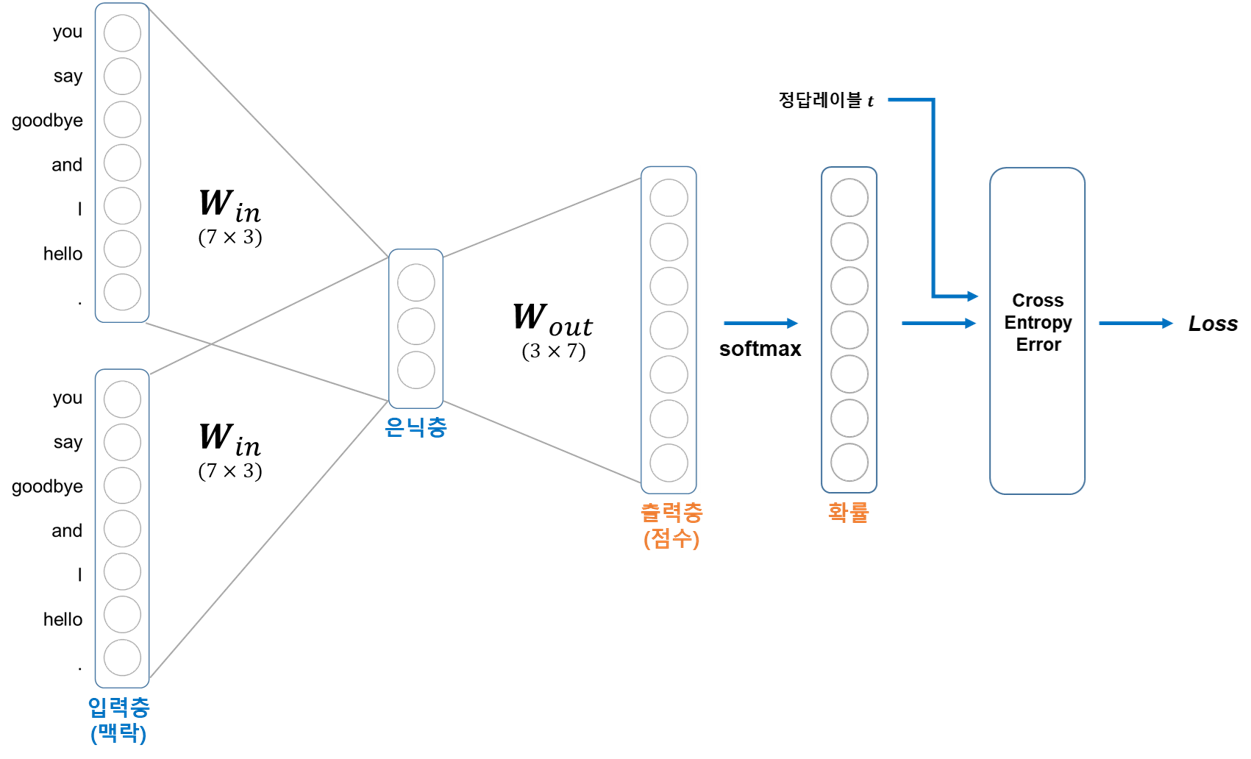
- 앞에서 설명한 CBOW 모델에 Softmax 계층과 Cross Entropy error 계층을 추가. 이거만으로도 손실을 구할 수 있음

## 3.3 학습 데이터 준비
### 3.3.1 맥락과 타깃
- 입력은 '맥락'이다.
- 정답 레이블은 맥락에 둘러싸인 단어, '타깃'이다.
- 목표 : 신경망에 '맥락'을 입력했을때 '타깃'이 출현할 확률을 높이는 것

In [15]:
import sys
from common.util import preprocess

In [17]:
text='You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
print(corpus)

[0 1 2 3 4 1 5 6]


In [18]:
print(id_to_word)

{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


그런 다음 단어 ID의 배열인 corpus로부터 맥락과 타깃을 만들어내보자.  
corpus를 주면 맥락과 타깃을 반환하는 함수를 작성한다.
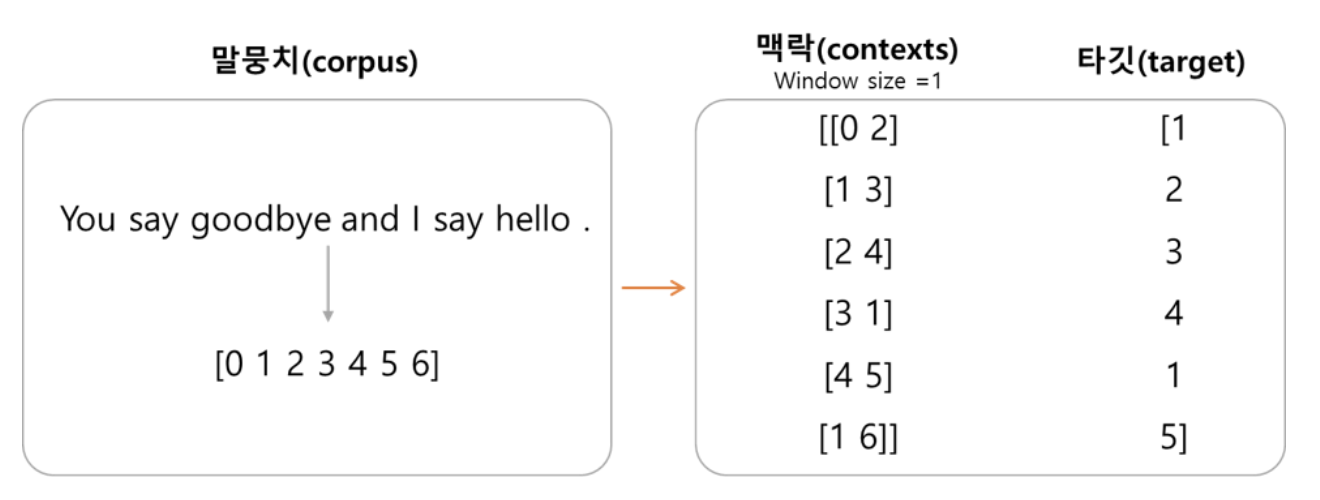

In [ ]:
# common/util.py
def create_contexts_target(corpus, window_size=1):
    '''맥락과 타깃 생성
    :param corpus: 말뭉치(단어 ID 목록)
    :param window_size: 윈도우 크기(윈도우 크기가 1이면 타깃 단어 좌우 한 단어씩이 맥락에 포함)
    :return: (맥락, 타겟)의 np.array
    '''
    target = corpus[window_size:-window_size]
    contexts = []
    
    for idx in range(window_size, len(corpus)-window_size):
        cs = []
        # wiondow_size만큼 타겟 단어 좌우 context 가져오기
        for t in range(-window_size, window_size+1):
            if t != 0:
                cs.append(corpus[idx + t])
        contexts.append(cs)
        
    return np.array(contexts), np.array(target)

In [20]:
from common.util import create_contexts_target
contexts,target=create_contexts_target(corpus,window_size=1)

In [22]:
print(contexts)

[[0 2]
 [1 3]
 [2 4]
 [3 1]
 [4 5]
 [1 6]]


In [23]:
print(target)

[1 2 3 4 1 5]


### 3.3.2 원핫 표현으로 변환
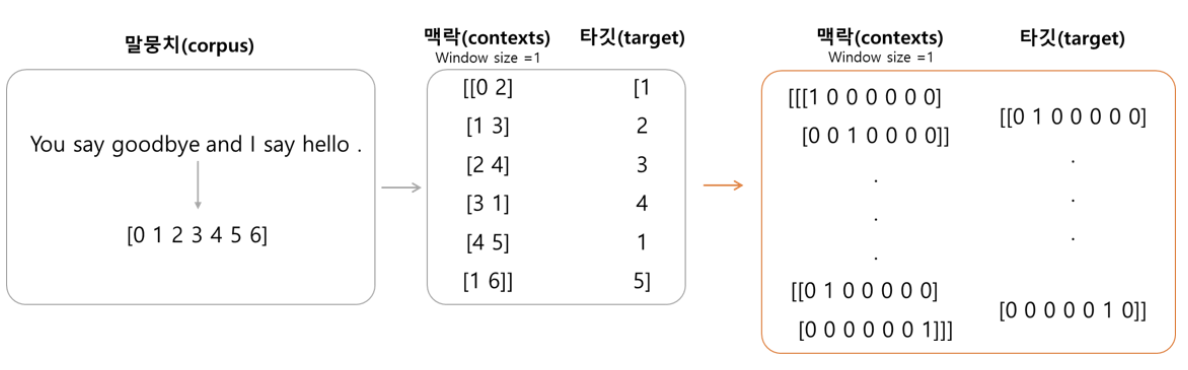

In [24]:
import sys
from common.util import preprocess, create_contexts_target, convert_one_hot

In [25]:
#corpus 준비
text='You say goodbye and I say hello.'

In [26]:
#전처리
corpus,word_to_id,id_to_word = preprocess(text)

In [27]:
#맥락과 타깃으로 나누기
contexts,target = create_contexts_target(corpus,window_size=1)

In [28]:
vocab_size=len(word_to_id)
target=convert_one_hot(target,vocab_size)
contexts=convert_one_hot(contexts,vocab_size)

# 3.4 CBOW 모델 구현

In [ ]:
import sys
import numpy as np
from common.layers import MatMul, SoftmaxWithLoss

class SimpleCBOW:
    def __init__(self, vocab_size, hidden_size): #이 초기화메서드는 인수로 어휘 수와 hidden layer의 뉴런수를 받.
        V,H = vocab_size, hidden_size
        
        # 가중치 초기화
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(H, V).astype('f')
        
        #레이어 생성
        self.in_layer0 = MatMul(W_in) #입력층 2개
        self.in_layer1 = MatMul(W_in)
        self.out_layer = MatMul(W_out) #출력층 1개
        self.loss_layer = SoftmaxWithLoss()
        
        #모든 가중치와 기울기를 리스트에 모은다.
        layers=[self.in_layer0, self.in_layer1, self.out_layer]
        self.params, self.grads = [],[]
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads
        
        #인스턴스 변수에 단어의 분산 표현을 저장한다.
        self.word_vecs1 = W_in
        self.word_vecs2 = W_out.T
    
    #순전파
    def forward(self, contexts, target): #맥락과 타깃을 받아서 손실을 반환한다.
        h0 = self.in_layer0.forward(contexts[:, 0])
        h1 = self.in_layer1.forward(contexts[:, 1])
        h = (h0 + h1) * 0.5
        score = self.out_layer.forward(h)
        loss = self.loss_layer.forward(score, target)
        return loss
    
    def backward(self, dout=1):
        ds = self.loss_layer.backward(dout)
        da = self.out_layer.backward(ds)
        da *= 0.5
        self.in_layer1.backward(da)
        self.in_layer0.backward(da)
        return None

class를 이용하면 `def __init__(self,something)`을 쓰게 된다.   
클래스 구성을 사용하는 이유  
 - 몇 번이고 재사용할 수 있다.
 - 코드 수정을 최소화한다.
 - 함수 실행중에, 함수 자신을 다시 호출하는 처리가 가능하다.
 - 클래스 내에 여러개의 메서드를 정의하는 것이 가능하다.

### 3.4.1 학습 코드 구현

In [35]:
import sys
sys.path.append('/Users/minjikim/GitHub/NLP-studies/chap03')
from common.trainer import Trainer
from common.optimizer import Adam #Adam : 매개변수 갱신 방법
from simple_cbow import SimpleCBOW
from common.util import preprocess, create_contexts_target, convert_one_hot

window_size=1
hidden_size=2
batch_size=3
max_epoch = 1000

text='You say goodbye and I say hello'
corpus,word_to_id,id_to_word=preprocess(text)

vocab_size=len(word_to_id)
# cbow 학습 데이터셋 생성
contexts, target = create_contexts_target(corpus, window_size)
# Input에 맞는 one-hot 표현 변환
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

# 모델 초기화
model = SimpleCBOW(vocab_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer) #학습데이터로부터 미니배치를 선택한 다음, 신경망에 입력해 기울기를 구하고, 그 기울기를 Optimizer에 넘겨 매개변수를 갱신한다.

In [36]:
# 학습
trainer.fit(contexts, target, max_epoch, batch_size)

| epoch 1 |  iter 1 / 1 | time 0[s] | loss 1.79
| epoch 2 |  iter 1 / 1 | time 0[s] | loss 1.79
| epoch 3 |  iter 1 / 1 | time 0[s] | loss 1.79
| epoch 4 |  iter 1 / 1 | time 0[s] | loss 1.79
| epoch 5 |  iter 1 / 1 | time 0[s] | loss 1.79
| epoch 6 |  iter 1 / 1 | time 0[s] | loss 1.79
| epoch 7 |  iter 1 / 1 | time 0[s] | loss 1.79
| epoch 8 |  iter 1 / 1 | time 0[s] | loss 1.79
| epoch 9 |  iter 1 / 1 | time 0[s] | loss 1.79
| epoch 10 |  iter 1 / 1 | time 0[s] | loss 1.79
| epoch 11 |  iter 1 / 1 | time 0[s] | loss 1.79
| epoch 12 |  iter 1 / 1 | time 0[s] | loss 1.79
| epoch 13 |  iter 1 / 1 | time 0[s] | loss 1.79
| epoch 14 |  iter 1 / 1 | time 0[s] | loss 1.79
| epoch 15 |  iter 1 / 1 | time 0[s] | loss 1.79
| epoch 16 |  iter 1 / 1 | time 0[s] | loss 1.79
| epoch 17 |  iter 1 / 1 | time 0[s] | loss 1.79
| epoch 18 |  iter 1 / 1 | time 0[s] | loss 1.79
| epoch 19 |  iter 1 / 1 | time 0[s] | loss 1.79
| epoch 20 |  iter 1 / 1 | time 0[s] | loss 1.79
| epoch 21 |  iter 1 / 1 | ti

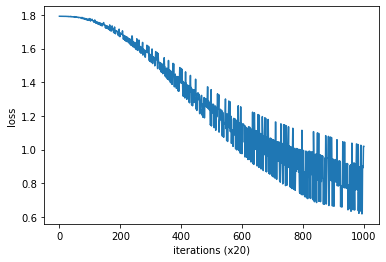

In [37]:
trainer.plot()

학습을 거듭할수록 손실이 줄어드는 것이 보인다. 학습이 끝난후의 매개변수 확인

In [1]:
# 입력층 matmul 계층의 가중치가 word_vecs에 저장되어있음
word_vecs1 = model.word_vecs1
for word_id, word in id_to_word.items():
    print(word, word_vecs1[word_id])

NameError: name 'model' is not defined

In [43]:
# Word Embedding 살펴보기
word_vecs2 = model.word_vecs2
for word_id, word in id_to_word.items():
    print(word, word_vecs2[word_id])

you [-0.28416413  1.1918285 ]
say [ 1.0872607 -0.7961626]
goodbye [-1.0557495 -0.2749296]
and [ 0.85819066 -0.10468912]
i [-1.0669149 -0.3060324]
hello [-0.28206375  1.2020544 ]


그리고 마침내 우리는 단어를 밀집벡터로 나타낼 수 있게 되었다. 이 밀집벡터가 바로 분산표현이다.   
이 분산표현은 '단어의 의미'를 잘 파악한 벡터 표현으로 되어있을 것이라 기대할 수 있다.

그러나.. 말뭉치가 너무 작기 때문에 결과가 좋지 않을 것이다. 또한 현 시점에서 Cbow 모델 구현은 몇가지 문제가 있다.

## 3.5 word2vec 보충
### 3.5.2 skip-gram 모델

타겟 단어로부터 맥락 단어를 구하는 것이다. 입력층은 하나, 출력층은 맥락의 수만큼 존재한다. 개별 손실들을 모두 더한 값이 최종 손실이 된다. 